# Importing data

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

account_df = pd.read_csv('data/account.csv',sep=';')
card_df = pd.read_csv('data/card_dev.csv', sep=';')
client_df = pd.read_csv('data/client.csv',sep=';')
disp_df = pd.read_csv('data/disp.csv',sep=';')
district_df = pd.read_csv('data/district.csv',sep=';')
loan_df = pd.read_csv('data/loan_dev.csv', sep=';')
trans_df = pd.read_csv("data/trans_dev.csv",sep=";", low_memory=False)

# Account Stats

In [2]:
account_df.rename(columns={'frequency':'account_frequency'}, inplace=True)
account_df.rename(columns={'date':'account_date'}, inplace=True)

account_df.loc[account_df['account_frequency'] == 'monthly issuance', 'account_frequency'] = 'monthly'
account_df.loc[account_df['account_frequency'] == 'weekly issuance', 'account_frequency'] = 'weekly'
account_df.loc[account_df['account_frequency'] == 'issuance after transaction', 'account_frequency'] = 'after-transaction'

#Frequency from text data to numerical
account_df['account_frequency']= label_encoder.fit_transform(account_df['account_frequency'])


account_df['account_date'] = pd.to_datetime(account_df['account_date'], format='%y%m%d')

acount_date_year = []
for i in account_df.index:
    acount_date_year.append(account_df['account_date'][i].year)

account_df['account_year'] = acount_date_year

print(account_df.head())
account_df.to_csv('refined/account.csv')

   account_id  district_id  account_frequency account_date  account_year
0         576           55                  1   1993-01-01          1993
1        3818           74                  1   1993-01-01          1993
2         704           55                  1   1993-01-01          1993
3        2378           16                  1   1993-01-01          1993
4        2632           24                  1   1993-01-02          1993


# Client Processing


In [3]:
client_df.rename(columns={'district_id':'client_district_id'}, inplace=True)
client_df.rename(columns={'birth_number':'client_birth_number'}, inplace=True)


age = []
gender = []
birth = []
get_birth_date = lambda x : pd.to_datetime('19'+str(x)[0:2] + str(x)[2:4] + str(x)[4:6])
for x in client_df['client_birth_number']:
    month = int(str(x)[2:4])
    if month > 12:
        gender.append('F')
        x -= 5000
    else:
        gender.append('M')
    
    birth_date = get_birth_date(x)
    birth.append(birth_date)
    age.append((datetime.now() - birth_date).days // 365)

client_df['client_birth_number'] = birth

birth_year = []
for i in client_df.index:
    birth_year.append(client_df['client_birth_number'][i].year)

client_df['birth_year'] = birth_year
    
print(client_df.head())

client_df['client_age'] = age
client_df['client_gender'] = gender


client_df['client_gender']= label_encoder.fit_transform(client_df['client_gender'])

client_df.to_csv('refined/client.csv')

   client_id client_birth_number  client_district_id  birth_year
0          1          1970-12-13                  18        1970
1          2          1945-02-04                   1        1945
2          3          1940-10-09                   1        1940
3          4          1956-12-01                   5        1956
4          5          1960-07-03                   5        1960


# Disposition Processing

In [4]:
disp_df = disp_df.loc[disp_df.type == "OWNER"]
disp_df.drop(columns=['type'], inplace=True)
disp_df.rename(columns={'type':'disp_type'}, inplace=True)
disp_df.to_csv('refined/disposition.csv')

# Transaction Processing

In [5]:
trans_df.rename(columns={'date' : 'trans_date'}, inplace=True)
trans_df.rename(columns={'type' : 'trans_type'}, inplace=True)
trans_df.rename(columns={'operation' : 'trans_operation'}, inplace=True)
trans_df.rename(columns={'amount' : 'trans_amount'}, inplace=True)
trans_df.rename(columns={'balance' : 'trans_balance'}, inplace=True)
trans_df.rename(columns={'k_symbol' : 'trans_k_symbol'}, inplace=True)
trans_df.rename(columns={'bank' : 'trans_bank'}, inplace=True)
trans_df.rename(columns={'account': 'trans_account'}, inplace=True)

trans_df['trans_date'] = pd.to_datetime(trans_df['trans_date'], format='%y%m%d')

trans_date_year = []
for i in trans_df.index:
    trans_date_year.append(trans_df['trans_date'][i].year)

trans_df['trans_year'] = trans_date_year

#as colunas bank e account não são necessárias, trans_k_symbol têm muitos valores nulos
trans_df.drop(['trans_bank', 'trans_account', 'trans_k_symbol'], axis=1, inplace=True)

#withdrawal in cash para withdrawal
trans_df.loc[trans_df["trans_type"]=="withdrawal in cash","trans_type"] = "withdrawal" 
#se for withdrawal, o ammount é negativo
trans_df.loc[trans_df["trans_type"]=="withdrawal","trans_amount"] *= -1
print(trans_df.head())


trans_df.to_csv('refined/transaction.csv')

   trans_id  account_id trans_date trans_type               trans_operation  \
0   1548749        5270 1993-01-13     credit                credit in cash   
1   1548750        5270 1993-01-14     credit  collection from another bank   
2   3393738       11265 1993-01-14     credit                credit in cash   
3   3122924       10364 1993-01-17     credit                credit in cash   
4   1121963        3834 1993-01-19     credit                credit in cash   

   trans_amount  trans_balance  trans_year  
0         800.0          800.0        1993  
1       44749.0        45549.0        1993  
2        1000.0         1000.0        1993  
3        1100.0         1100.0        1993  
4         700.0          700.0        1993  


# Loan Processing

In [6]:

loan_df.rename(columns={'date':'loan_date'}, inplace=True)
loan_df.rename(columns={'amount':'loan_amount'}, inplace=True)
loan_df.rename(columns={'duration':'loan_duration'}, inplace=True)
loan_df.rename(columns={'payments':'loan_payments'}, inplace=True)
loan_df.rename(columns={'status':'loan_status'}, inplace=True)
loan_df.loc[loan_df["loan_status"]== -1,"loan_status"] *= 0

loan_df['loan_date'] = pd.to_datetime(loan_df['loan_date'], format='%y%m%d')

loan_date_year = []
for i in loan_df.index:
    loan_date_year.append(loan_df['loan_date'][i].year)
loan_df['loan_year'] = loan_date_year

loan_df.to_csv('refined/loan.csv')

# Credit Card Processing

In [7]:
card_df.rename(columns={'type' : 'card_type'}, inplace=True)
card_df.rename(columns={'issued' : 'card_issued'}, inplace=True)


card_df['card_issued'] = pd.to_datetime(card_df['card_issued'], format='%y%m%d')

issued_year = []
for i in card_df.index:
    issued_year.append(card_df['card_issued'][i].year)
card_df['car_issued_year'] = issued_year


card_df.to_csv('refined/card.csv')

# District (demograph) Processing

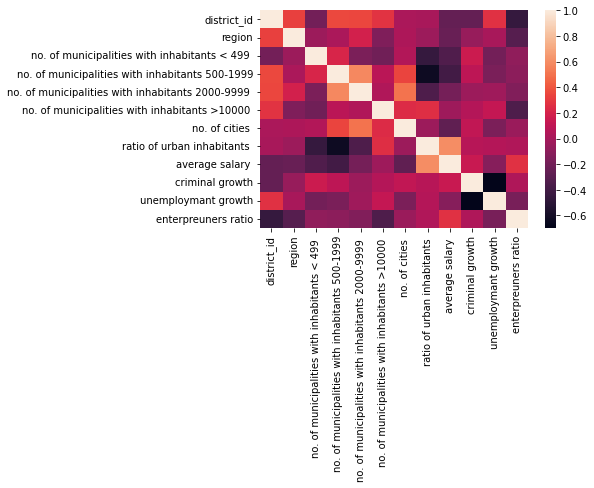

In [8]:
district_df.rename(columns={'code ' : 'district_id'}, inplace=True)
district_df["unemploymant rate '95 "] = pd.to_numeric(district_df["unemploymant rate '95 "], errors='coerce')
#filling NA values with mean
district_df["unemploymant rate '95 "].fillna(district_df["unemploymant rate '95 "].mean(), inplace=True)

district_df["no. of commited crimes '95 "] = pd.to_numeric(district_df["no. of commited crimes '95 "], errors='coerce')
#filling NA values with mean
district_df["no. of commited crimes '95 "].fillna(district_df["no. of commited crimes '95 "].mean(), inplace=True)

#growths
district_df["criminal growth"] = (district_df["no. of commited crimes '96 "] - district_df["no. of commited crimes '95 "]) / district_df["no. of inhabitants"]
district_df['unemploymant growth'] = district_df["unemploymant rate '96 "] - district_df["unemploymant rate '95 "]

#simplifying ratios lmao
district_df['enterpreuners ratio'] = district_df['no. of enterpreneurs per 1000 inhabitants '] / 1000
district_df['ratio of urban inhabitants '] = district_df['ratio of urban inhabitants '] / 100

#Region attribute to numerical
district_df['region']= label_encoder.fit_transform(district_df['region'])

district_df.drop(columns=['name ', 'no. of enterpreneurs per 1000 inhabitants ', 'no. of inhabitants',
        "unemploymant rate '96 ", "no. of commited crimes '96 ",
        "unemploymant rate '95 ", "no. of commited crimes '95 "], inplace=True)

corr = district_df.corr()
sns.heatmap(corr);
district_df.to_csv('refined/district.csv')

# Merging

In [9]:
refined_df = loan_df.merge(disp_df, on='account_id')
refined_df = refined_df.merge(client_df, on='client_id')
refined_df = refined_df.merge(account_df, on='account_id')
refined_df = refined_df.merge(district_df, left_on='client_district_id', right_on='district_id')
refined_df = refined_df.merge(trans_df, on='account_id')
#refined_df = refined_df.merge(card_df, on='disp_id')
get_age = lambda initial_date, cur_date: cur_date.year - initial_date.year - ((cur_date.month, cur_date.day) < (initial_date.month, initial_date.day))
get_account_age = lambda initial_date,cur_date : (cur_date.year - initial_date.year) * 12 + cur_date.month - initial_date.month
refined_df['age on loan'] = refined_df.apply(lambda row: get_age(row['client_birth_number'], row['loan_date']), axis=1)
refined_df['account age at loan'] = refined_df.apply(lambda row: get_account_age(row['account_date'], row['loan_date']), axis=1)
refined_df.drop(columns={
    'account_id', 'disp_id', 'client_id', 'client_district_id', 'district_id_x', 'district_id_y', 'trans_id', 'client_birth_number', 'client_age', 'account_date',
    'loan_date', 'trans_date', 'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ',
    'no. of municipalities with inhabitants >10000 ', 'no. of cities '
})
refined_df.to_csv('refined/final_data.csv',sep=';')





In [10]:
refined_df

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,loan_year,disp_id,client_id,...,enterpreuners ratio,trans_id,trans_date,trans_type,trans_operation,trans_amount,trans_balance,trans_year,age on loan,account age at loan
0,5314,1787,1993-07-05,96396,12,8033,0,1993,2166,2166,...,0.100,523621,1993-03-22,credit,credit in cash,1100.0,1100.0,1993,45,4
1,5314,1787,1993-07-05,96396,12,8033,0,1993,2166,2166,...,0.100,524054,1993-04-21,credit,credit in cash,9900.0,11000.0,1993,45,4
2,5314,1787,1993-07-05,96396,12,8033,0,1993,2166,2166,...,0.100,524055,1993-05-21,credit,credit in cash,5800.0,16800.0,1993,45,4
3,5314,1787,1993-07-05,96396,12,8033,0,1993,2166,2166,...,0.100,524056,1993-06-20,credit,credit in cash,3300.0,20100.0,1993,45,4
4,5316,1801,1993-07-11,165960,36,4610,1,1993,2181,2181,...,0.117,527445,1993-02-13,credit,credit in cash,700.0,700.0,1993,24,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24489,6015,5001,1996-11-09,110112,24,4588,1,1996,6042,6042,...,0.099,1468125,1996-10-28,credit,credit in cash,40890.0,122647.9,1996,33,11
24490,6015,5001,1996-11-09,110112,24,4588,1,1996,6042,6042,...,0.099,3668246,1996-10-31,credit,NaN,299.9,102247.7,1996,33,11
24491,6015,5001,1996-11-09,110112,24,4588,1,1996,6042,6042,...,0.099,1468352,1996-10-31,withdrawal,withdrawal in cash,-14.6,102233.1,1996,33,11
24492,6015,5001,1996-11-09,110112,24,4588,1,1996,6042,6042,...,0.099,1468396,1996-11-02,withdrawal,withdrawal in cash,-28800.0,106858.1,1996,33,11


In [11]:
import data_understanding_utils as du
du.info_data(refined_df,"isnull","")

Number of null values: 
 loan_id                                                 0
account_id                                              0
loan_date                                               0
loan_amount                                             0
loan_duration                                           0
loan_payments                                           0
loan_status                                             0
loan_year                                               0
disp_id                                                 0
client_id                                               0
client_birth_number                                     0
client_district_id                                      0
client_age                                              0
client_gender                                           0
district_id_x                                           0
account_frequency                                       0
account_date                                   